In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import hdbscan
import nltk
import spacy

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('hsbc_twitter_DATA_not GENERAL.csv')
df.rename(columns={"NEW HUMAN CATEGORY\n 0-1000 /4000-4468 Michael\n 1000-2500 Mehmet \n 2500-4000 Aryamaan":"labels"}, inplace = True)
df.head()

tweet  \
0   2  @LondOgrad Hello Eugene, we do apologise for t...   
1   8  @ncohen4 @CooperativeBank @HSBC @HSBCUKBusines...   
2   9  @sharaola Good morning, sorry for your experie...   
3  11        @Bounce_BackLoan Still not a peep from HSBC   
4  15  @djm2481 @mgcmitchell @HSBC_UK Thanks for the ...   

  HUMAN CATEGORY\n ARYAMAAN:1-1000,4000-4468\n Michael-Mehmet:1000-4000  \
0                            CUSTOMER_SERVICE_ISSUES                      
1                                     BAD REPUTATION                      
2                            CUSTOMER_SERVICE_ISSUES                      
3                                              DELAY                      
4                          Customer Service Response                      

                SUB CATEGORY                   COMMENTS  \
0                        NaN       bad customer service   
1                        NaN                        NaN   
2                        NaN       bad customer service   
3  Delay_in_bounce_back_loan  delay in bounce back loan   
4                        NaN     customer service reply   

                      labels             SUB CATEGORY.1  \
0  Customer Service Response                        NaN   
1                    General                        NaN   
2  Customer Service Response                        NaN   
3                      DELAY  Delay_in_bounce_back_loan   
4  Customer Service Response                        NaN   

                  COMMENTS.1 human category (Tarun)  SUB CATEGORY.2  \
0     customer service reply                    NaN             NaN   
1                        NaN                    NaN             NaN   
2     customer service reply                    NaN             NaN   
3  delay in bounce back loan                    NaN             NaN   
4     customer service reply                    NaN             NaN   

   COMMENTS.2             NEW CATEGORY              keyword  \
0         NaN  customer_service issues                delay   
1         NaN           Bad_reputation              unhappy   
2         NaN  customer_service issues      customerservice   
3         NaN    Delay_Bounceback_Loan  delay , no response   
4         NaN                  General          any queries   

                         human - category  \
0                                   Delay   
1               {'category': 'Reputation'   
2  {'category': 'customer_service issues'   
3         {'category': 'Bounce back loan'   
4               {'category': 'Reputation'   

                                human - Sub category  \
0                                     delay in calls   
1                     subcategory': 'Bad reputation'   
2                    subcategory': 'customerservice'   
3            subcategory': 'Bounce back loan delays'   
4  subcategory': 'General Response from Bank (tha...   

                                 Comment HUMAN CATGEORY_NEW(ARYA)  \
0                            Huge Queues  customer_service_issues   
1  worst experience from customer – mess           BAD_REPUTATION   
2             General response from bank                  General   
3                               No reply    DELAY_BOUNCEBACK_LOAN   
4             General response from bank                      NaN   

              location   COMMENTS (FROM PARIJAAT)  \
0           London, UK                        NaN   
1    Plymouth, England                        NaN   
2         Cairo, Egypt  General message from hsbc   
3  Enschede, Nederland                      DELAY   
4       United Kingdom                        NaN   

                          Category                               Sub-category  
0             {'category': 'Delay'  subcategory': 'Delay in bounce back loan'  
1        {'category': 'Reputation'            subcategory': 'Good reputation'  
2        {'category': 'Reputation'            subcategory': 'Good reputation'  
3  {'category': 'Bounce back loan'    subcategory': 'Bounce b

In [4]:
df.labels.value_counts().sum()

4462

In [3]:
# reducing General Data 1500
drop_indices = np.random.choice(df.loc[df["labels"]=="General"].index, 1500, replace=False)
df = df.drop(drop_indices)

In [4]:
df.labels.value_counts()

General                      769
DELAY                        716
Customer Service Response    653
BAD REPUTATION               229
CUSTOMER_SERVICE_ISSUES      227
Customer Query               168
GOOD REPUTATION              101
COVID19                       50
CHURN                         37
ESG                            6
Junk                           4
Language                       2
Name: labels, dtype: int64

In [5]:
df.tweet.str.contains("bye").sum()

3

In [6]:
# label = pd.DataFrame(df.groupby("labels", as_index=False)["tweet"].apply(lambda x: " ".join(x)))
# bad_repu = label[label.labels == "BAD REPUTATION"]["reviewText"].tolist()

In [7]:
import string
def remove_punc(txt):
    txt = "".join([c for c in txt if c not in string.punctuation])
    txt = txt.replace("\n", " ")
    return txt.lower()
df.tweet = df.tweet.apply(lambda x: remove_punc(x))

In [8]:
replace_word = {"covid":"covid", "corona":"covid","pandemi":"covid", 
                "bouncebackloan":"bounce back loan", "noresponse":"no response", 
                "bounceback":"bounce back", "backloan":"back loan","on hold":"on_hold",
                "bbl":"bounce back loan", "any news":"any_news","give up":"give_up", 
                "gave up":"give_up", "well done":"well_done"}
for key, value in replace_word.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [9]:
junk_words = "nt citi kashif a very were yet than through via here rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [10]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', text)
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [11]:
def clean_data(text, small_word_lmt=0, extra_words=junk_words_list,replace_word=replace_word):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if not word.startswith('http') \
           and word.isalpha() \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.tweet = df.tweet.apply(lambda x: clean_data(x))

In [5]:
"lai".isalpha()

True

In [12]:
df.tweet.str.contains("worst").sum()

70

In [13]:
def word_root(text):
    list_data3=[]
    
    doc = spaci(text)
    for token in doc:
        if token.text=="worst" or token.text=="worse":
            lemma = token.text
        else:
            lemma = token.lemma_
        if lemma != "do":
            list_data3.append(lemma)
    return " ".join(list_data3)
df.tweet = df.tweet.apply(lambda x: word_root(x))  

In [14]:
df.tweet.str.contains("bye").sum()

5

In [15]:
word_root("worst")

'worst'

In [16]:
# adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df["eng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))
# df["noneng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i not in eng_words]))
# df.noneng.tolist()

In [17]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [18]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(10)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [19]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [20]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [21]:
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [22]:
bigrams

['can not',
 'contest contestalert',
 'fromthequizmaster contest',
 'stay safe',
 'absolute joke',
 'that s',
 'what s',
 'live chat',
 'name postcode',
 'tatacrucible fromthequizmaster',
 'full name',
 'you re',
 'information hence',
 'hence request',
 'contestalert tatacrucible',
 'refer link',
 'post code',
 'direct message',
 'order assist',
 'credit card',
 'click link',
 'concerned team',
 'link below',
 'name post',
 'have nt',
 'let know',
 'send sm',
 'mobile number',
 'good morning',
 'week ago',
 'two week',
 'team touch',
 'hello mr',
 'exist customer',
 'customer care',
 'hear anything',
 'hear nothing',
 'set feeder',
 'need information',
 'assist need',
 'feeder account',
 'sorry hear',
 'please click',
 'thank write',
 'phone service',
 'worst customer',
 'still wait',
 'customer service',
 'personal account',
 'bounce back',
 'request call',
 'back loan',
 'still nothing',
 'I think',
 'call phone',
 'hello sorry',
 'apply feeder',
 'please send',
 'business customer',

In [23]:
trigrams

['sm hsbcsm register',
 'hsbcsm register mobile',
 'fromthequizmaster contest contestalert',
 'regret every second',
 'stay safe claude',
 'connect minute person',
 'tatacrucible fromthequizmaster contest',
 'absolute joke worst',
 'contest contestalert tatacrucible',
 'regard concern refer',
 'mobile number fetch',
 'send sm hsbcsm',
 'minute person set',
 'full name postcode',
 'work quickly possible',
 'team touch youalpa',
 'information hence request',
 'register mobile number',
 'number fetch detail',
 'name post code',
 'digit complaint number',
 'full name post',
 'concern refer link',
 'name postcode dm',
 'need information hence',
 'service regard concern',
 'write order assist',
 'experience business life',
 'kindly write concern',
 'person set feeder',
 'fetch detail send',
 'click link below',
 'dm direct message',
 'provide full name',
 'team check priority',
 'order assist need',
 'kindly send sm',
 'business life year',
 'direct message use',
 'second call connect',
 'ca

In [24]:
replace_ngrams = {"bounce back loan":"bounce_back_loan", "name post code":"name_post_code","full name":"full_name",
                  "credit card":"credit_card","click link below":"click_link_below",
                  "worst customer experience":"worst_customer_experience",
                  "thank respond back":"thank_respond_back","phone service team":"phone_service_team",
                  "thank write back":"thank_write_back","feeder account":"feeder_account", "still wait":"still_wait",
                  "business account":"business_account","business customer":"business_customer","good morning":"good_morning",
                  "week ago":"week_ago","post code":"post_code","click link":"click_link","let know":"let_know",
                  "call back":"call_back","personal account":"personal_account","refer link":"refer_link","link below":"link_below",
                  "name post":"name_post","hear nothing":"hear_nothing","sorry hear":"sorry_hear", "hello thank":"hello_thank",
                  "loan application":"loan_application","loan apply":"loan_apply"}
for key, value in replace_ngrams.items():
    if value == "bounce_back_loan":
        df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)
    else:
        df.tweet.replace(f"\S*{key}\S*" , f"{value} "*3, regex=True, inplace = True)
    

In [25]:
df.tweet.str.contains("worst").sum()

70

In [26]:
# replace_key_words = ['delay', 'wait', 'on_hold', 'any_news', 'awful', 'disappointed', 'give_up', 'regret', 'worse', 'worst', 'unhappy', 'sucksunbelievable', 'frustrated', 'disgusted', 'happy', 'disgrace', 'awesome', 'fantastic', 'well_done', 'great', 'leave', 'bye', 'switch', 'covidenvironment', 'fossil', 'coal', 'fuel', 'climate', 'carbon', 'best', 'wonderfull']
# for key_word in replace_key_words:
#     df.tweet.replace(f"\S*{key_word}\S*" , f"{key_word} "*2, regex=True, inplace = True)


In [27]:
df.drop(df[df.tweet.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [28]:
df_clean = df.tweet
df_clean.shape

(2910,)

In [29]:
df_clean = df_clean.dropna()
df_clean.shape

(2910,)

In [30]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [31]:
from sentence_transformers import SentenceTransformer

In [32]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [33]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [34]:
# embeddings1[embeddings1.argmax()]

In [35]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [36]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)

In [37]:
import umap

In [38]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [39]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [40]:
PCA_bert1 = PCA(n_components=2).fit_transform(embeddings1)
PCA_bert1_norm = PCA(n_components=2).fit_transform(embeddings1_norm)

PCA_bert2 = PCA(n_components=2).fit_transform(embeddings2)
PCA_bert2_norm = PCA(n_components=2).fit_transform(embeddings2_norm)

In [41]:
tSNE_bert1 = TSNE(n_components=2).fit_transform(embeddings1)
tSNE_bert1_norm = TSNE(n_components=2).fit_transform(embeddings1_norm)

tSNE_bert2 = TSNE(n_components=2).fit_transform(embeddings2)
tSNE_bert2_norm = TSNE(n_components=2).fit_transform(embeddings2_norm)

In [42]:
from pyclustertend import hopkins
hopkins(UMAP_bert2,UMAP_bert2.shape[0])

0.07194614315048385

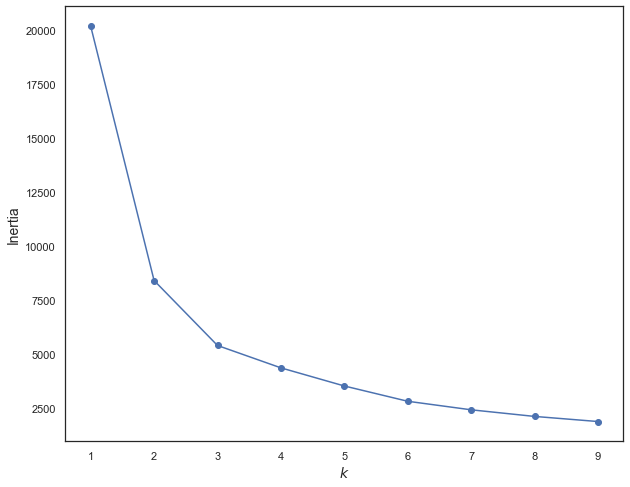

In [43]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_bert2)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [44]:
def cluster_results(Kmeans_clusters=4):
    
    ClusterDict = {}
    dim_embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                      "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                      "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                      "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                      "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                      "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)
        ClusterDict[key+"_hdbscan"] = hdbscan.HDBSCAN(min_samples = 30,
                           min_cluster_size=15,
                           metric = 'euclidean',
                           cluster_selection_epsilon = 0.25,
                           cluster_selection_method = "eom").fit_predict(val)
    return ClusterDict

In [45]:
clustering_result = cluster_results()

In [46]:
def plot(cluster = clustering_result):    
    reduced_dims = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                    "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                    "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                    "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                    "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                    "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm,
                    "UMAP_bert1_hdbscan" : UMAP_bert1, "UMAP_bert1_norm_hdbscan" : UMAP_bert1_norm, 
                    "UMAP_bert2_hdbscan" : UMAP_bert2, "UMAP_bert2_norm_hdbscan" : UMAP_bert2_norm,
                    "PCA_bert1_hdbscan" : PCA_bert1, "PCA_bert1_norm_hdbscan" : PCA_bert1_norm, 
                    "PCA_bert2_hdbscan" : PCA_bert2, "PCA_bert2_norm_hdbscan" : PCA_bert2_norm,
                    "tSNE_bert1_hdbscan" : tSNE_bert1, "tSNE_bert1_norm_hdbscan" :  tSNE_bert1_norm, 
                    "tSNE_bert2_hdbscan" : tSNE_bert2, "tSNE_bert2_norm_hdbscan" : tSNE_bert2_norm}

    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = reduced_dims[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_bert1--------------------
{0: 709, 1: 750, 2: 739, 3: 712}


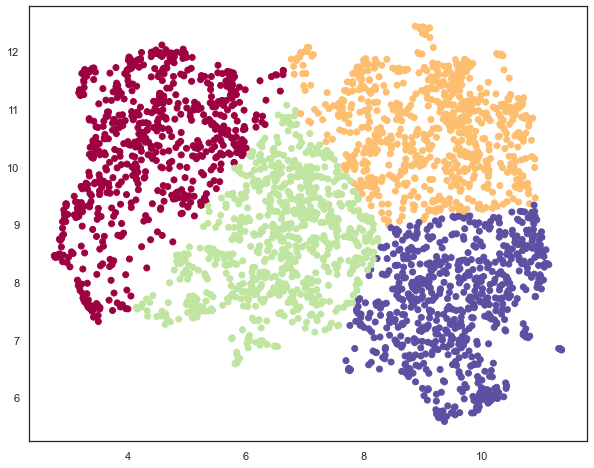

----------UMAP_bert1_hdbscan--------------------
{-1: 414, 0: 21, 1: 2475}


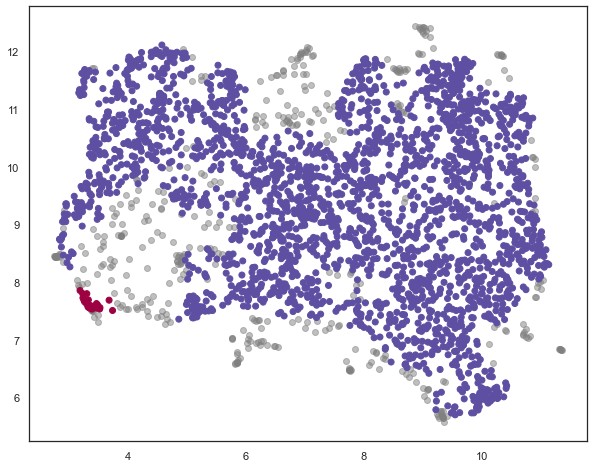

----------UMAP_bert1_norm--------------------
{0: 700, 1: 721, 2: 753, 3: 736}


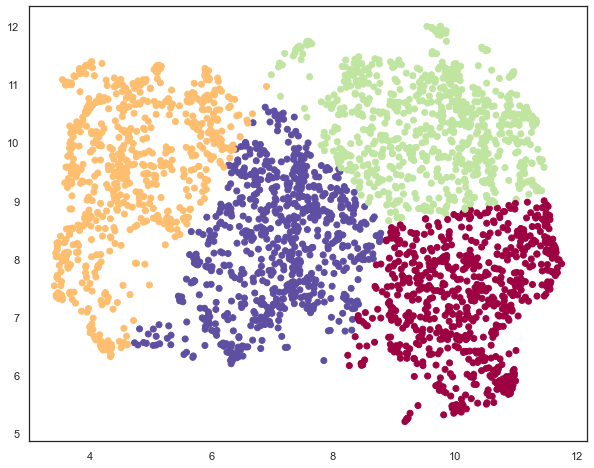

----------UMAP_bert1_norm_hdbscan--------------------
{-1: 347, 0: 37, 1: 2526}


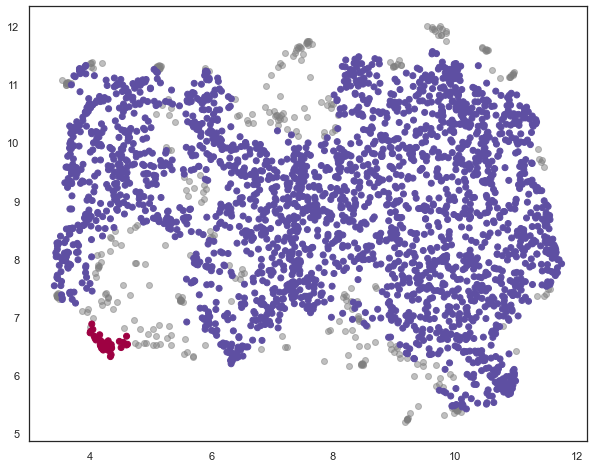

----------UMAP_bert2--------------------
{0: 1172, 1: 676, 2: 476, 3: 586}


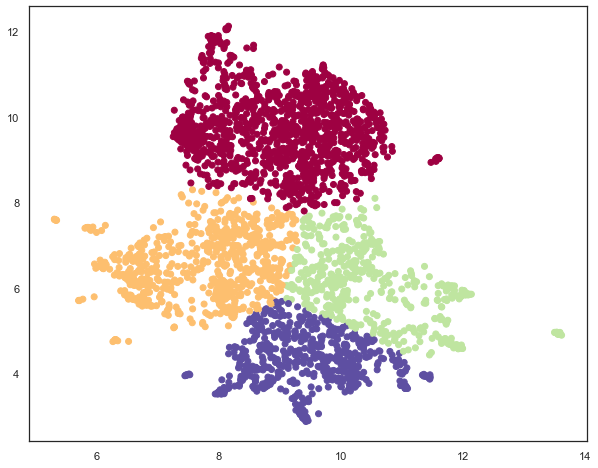

----------UMAP_bert2_hdbscan--------------------
{-1: 738, 0: 46, 1: 19, 2: 166, 3: 48, 4: 937, 5: 28, 6: 928}


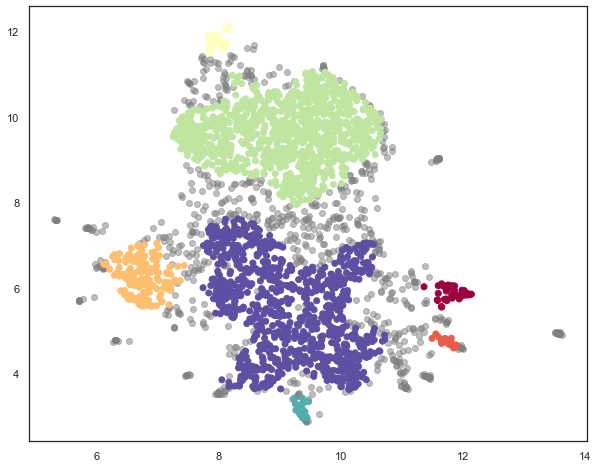

----------UMAP_bert2_norm--------------------
{0: 464, 1: 1182, 2: 672, 3: 592}


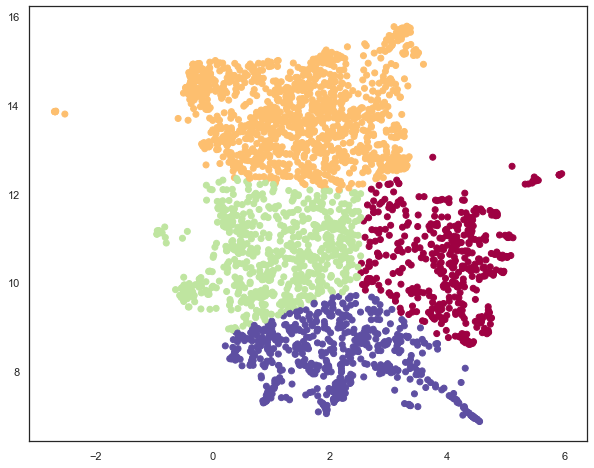

----------UMAP_bert2_norm_hdbscan--------------------
{-1: 1100, 0: 34, 1: 69, 2: 226, 3: 49, 4: 34, 5: 540, 6: 59, 7: 23, 8: 129, 9: 70, 10: 577}


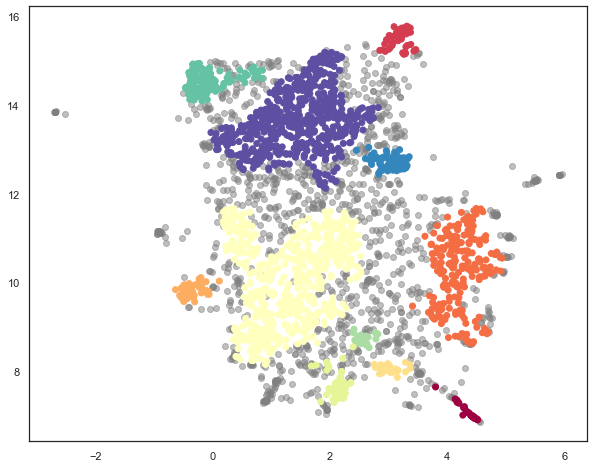

----------PCA_bert1--------------------
{0: 998, 1: 658, 2: 282, 3: 972}


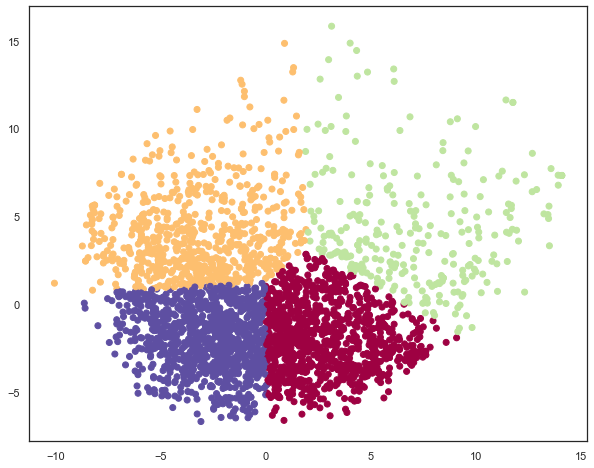

----------PCA_bert1_hdbscan--------------------
{-1: 1536, 0: 22, 1: 1352}


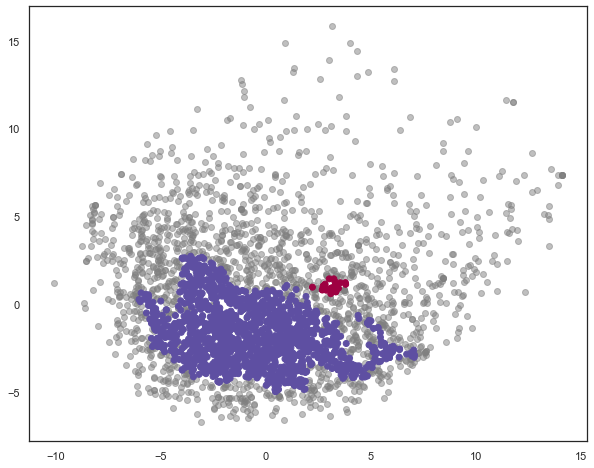

----------PCA_bert1_norm--------------------
{0: 949, 1: 697, 2: 970, 3: 294}


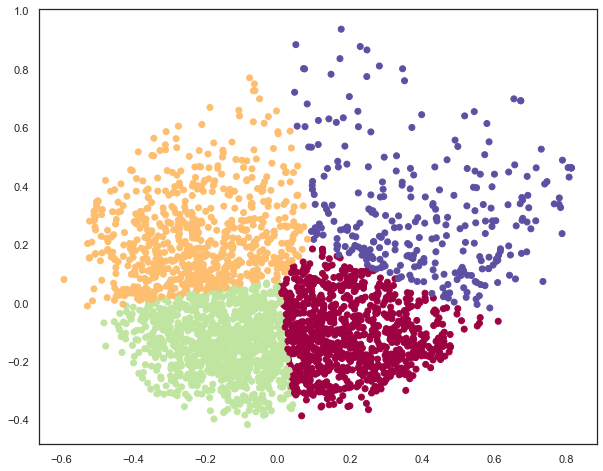

----------PCA_bert1_norm_hdbscan--------------------
{-1: 1381, 0: 1501, 1: 28}


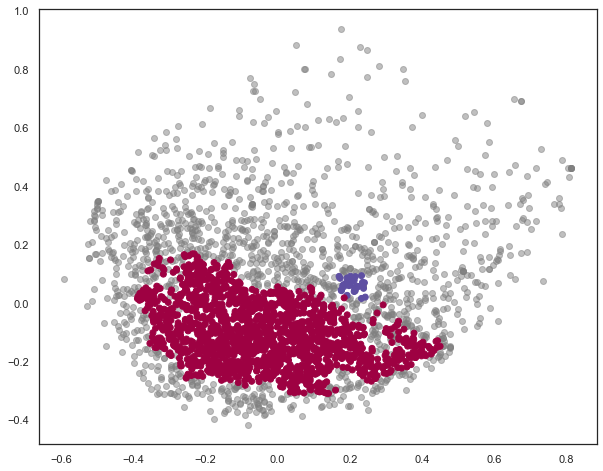

----------PCA_bert2--------------------
{0: 789, 1: 1009, 2: 479, 3: 633}


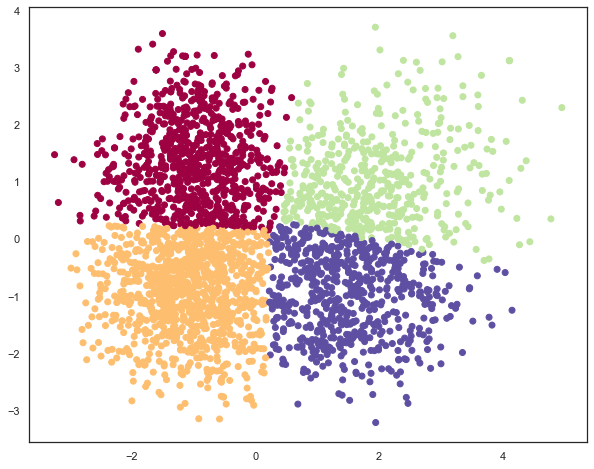

----------PCA_bert2_hdbscan--------------------
{-1: 1664, 0: 46, 1: 160, 2: 1040}


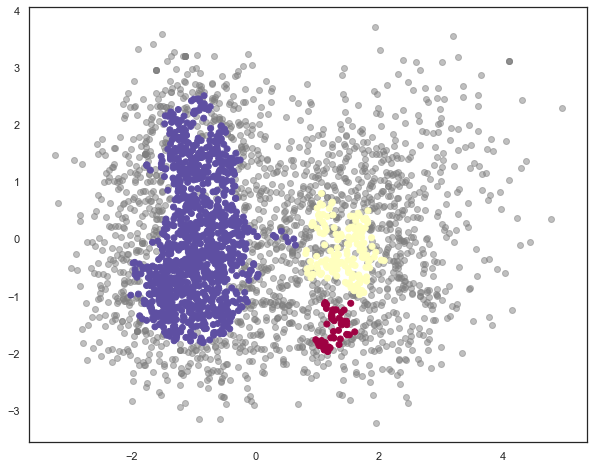

----------PCA_bert2_norm--------------------
{0: 978, 1: 816, 2: 507, 3: 609}


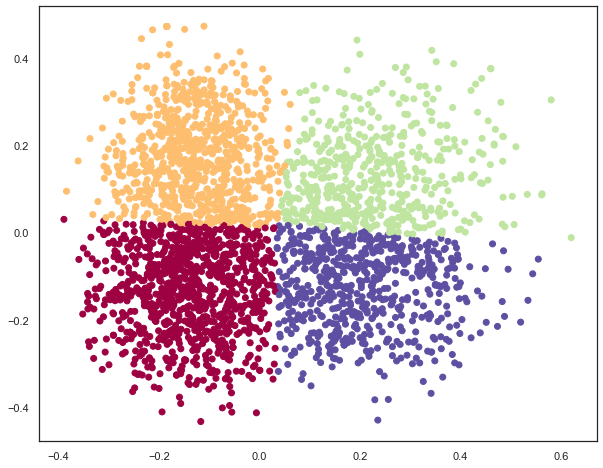

----------PCA_bert2_norm_hdbscan--------------------
{-1: 1584, 0: 208, 1: 1118}


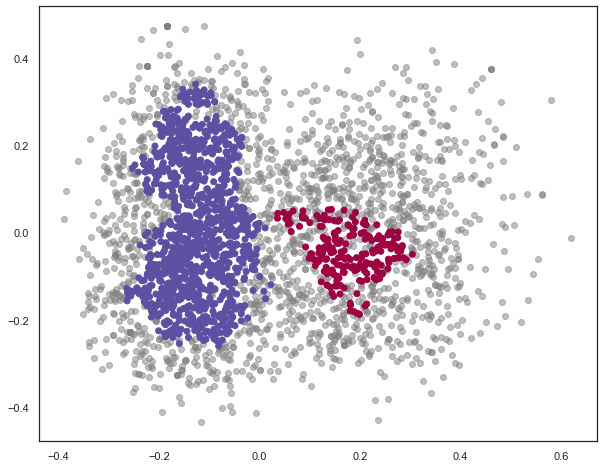

----------tSNE_bert1--------------------
{0: 772, 1: 788, 2: 708, 3: 642}


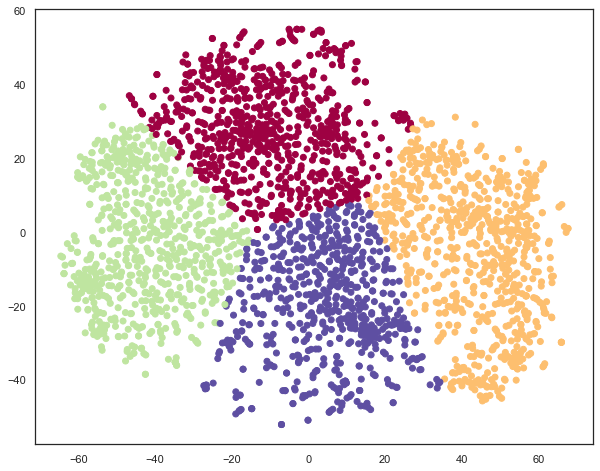

----------tSNE_bert1_hdbscan--------------------
{-1: 581, 0: 26, 1: 2303}


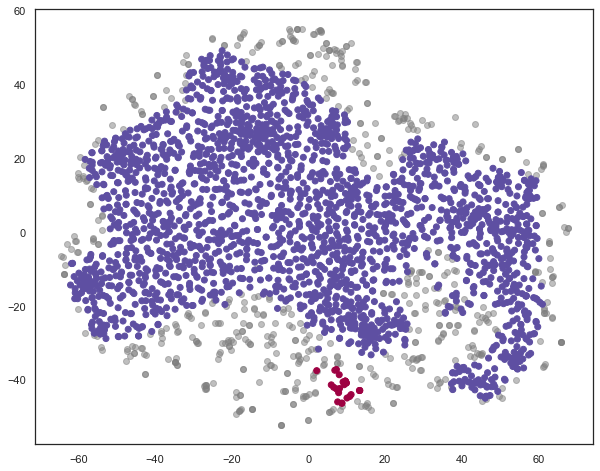

----------tSNE_bert1_norm--------------------
{0: 779, 1: 751, 2: 658, 3: 722}


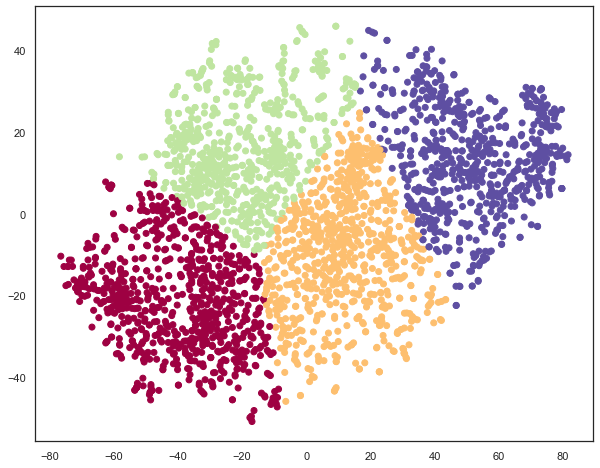

----------tSNE_bert1_norm_hdbscan--------------------
{-1: 723, 0: 15, 1: 2172}


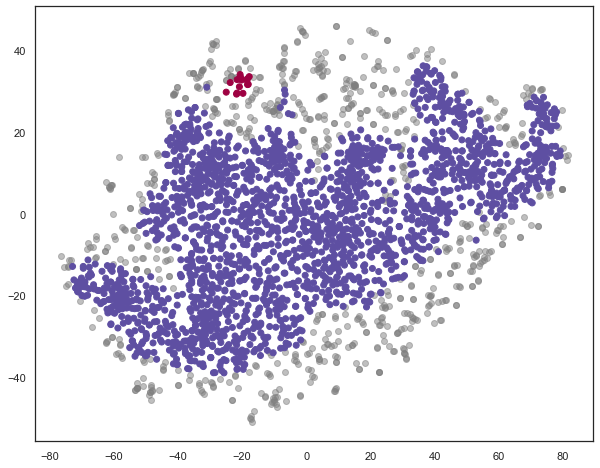

----------tSNE_bert2--------------------
{0: 791, 1: 804, 2: 726, 3: 589}


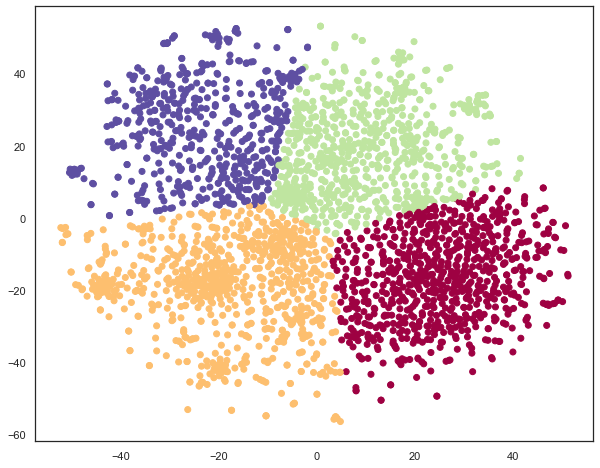

----------tSNE_bert2_hdbscan--------------------
{-1: 783, 0: 28, 1: 38, 2: 129, 3: 1885, 4: 47}


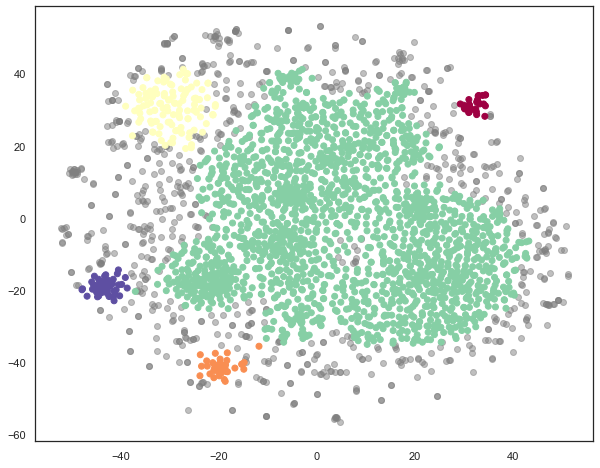

----------tSNE_bert2_norm--------------------
{0: 603, 1: 815, 2: 778, 3: 714}


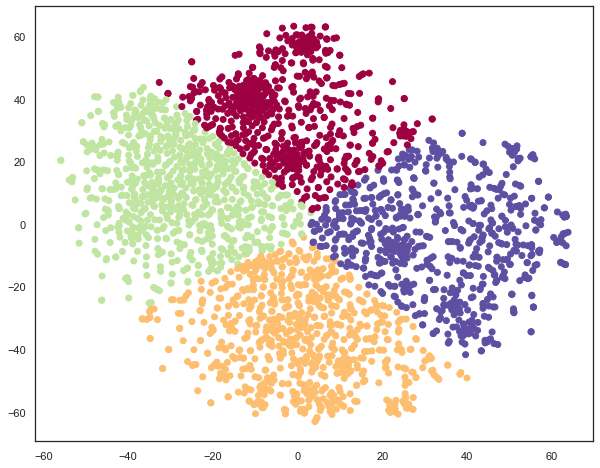

----------tSNE_bert2_norm_hdbscan--------------------
{-1: 1253, 0: 70, 1: 56, 2: 18, 3: 62, 4: 779, 5: 672}


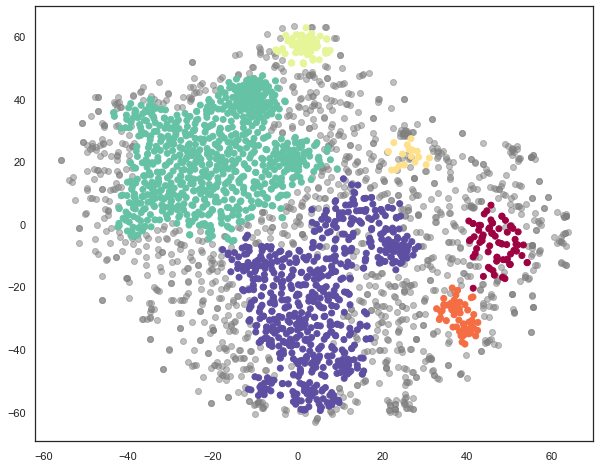

In [47]:
plot()

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [49]:
def cluster_words(clustering_result=clustering_result, top_n = 20, show_cross = False):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"tweet": " ".join})

        try : 
            del labeled_docs_try
        except :
            pass
        labeled_docs_try =pd.DataFrame(df_clean)
        labeled_docs_try["labels"] = df.labels
        labeled_docs_try["cluster"] = docs.cluster
        labeled_docs_try.head(50)
        cross = pd.crosstab(labeled_docs_try.labels, labeled_docs_try.cluster)
        if show_cross:
            display(cross)
        else: pass
                
        tfidf_vec = TfidfVectorizer()
        tfidf_mat = tfidfmatrix(labeled_docs.tweet, tfidf_vec)
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
        most_common.index = np.unique(cluster)
        display(most_common)

In [50]:
cluster_words(show_cross = True)

====================================UMAP_bert1=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              11   33   37  147
CHURN                        4    8    4   21
COVID19                     10    2   15   23
CUSTOMER_SERVICE_ISSUES     27   72   42   86
Customer Query              36   31   79   22
Customer Service Response  427   81   86   59
DELAY                        6  387  146  177
ESG                          1    0    1    4
GOOD REPUTATION             49   15   13   24
General                    135  119  311  148
Junk                         2    0    2    0
Language                     0    0    1    1

0               1           2                          3   \
0             thank       full_name       hello                hello_thank   
1  bounce_back_loan        week_ago  still_wait                      apply   
2  bounce_back_loan  feeder_account     account                      hello   
3  bounce_back_loan  feeder_account    customer  worst_customer_experience   

             4                 5               6            7             8   \
0        please        refer_link            send         help          team   
1           day              week  feeder_account        still  good_morning   
2         thank  business_account            call  credit_card      customer   
3  hear_nothing             apply         nothing         call       account   

           9               10        11           12          13           14  \
0  link_below  name_post_code  let_know         call  sorry_hear   click_link   
1     account            wait     email  application        call          say   
2       apply           email      help       please         pay  application   
3    business             day     worst          say        help        thank   

                 15     16      17                18                19  
0            kindly  check  number  click_link_below            detail  
1              sign   hour    time             thank  business_account  
2  loan_application   need     say  personal_account          business  
3           service  still   email              time              year

====================================UMAP_bert1_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION              29   1  198
CHURN                        5   0   32
COVID19                     19   0   31
CUSTOMER_SERVICE_ISSUES     26   3  198
Customer Query              21   1  146
Customer Service Response   92   0  561
DELAY                       34   1  681
ESG                          0   0    6
GOOD REPUTATION             19   0   82
General                    164  14  535
Junk                         2   1    1
Language                     1   0    1

0             1                 2          3        4   \
-1             thank  good_morning  bounce_back_loan       help  account   
 0              link        anyone          complain  complaint     form   
 1  bounce_back_loan         thank    feeder_account    account    apply   

       5     6        7          8      9            10      11          12  \
-1  covid   day   please      hello   call     customer     see       apply   
 0  hello  send  curious  doesthank  mayis  sortedthank  chance       ditto   
 1  hello  call      day      email   help     customer  please  still_wait   

         13     14        15           16       17           18          19  
-1  service  still    assist         gold     good        happy        hour  
 0     gent    get  lawofbtc        legit  mention      presume  prioritize  
 1     wait   week      time  application      say  hello_thank       still

====================================UMAP_bert1_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION             146   14   32   36
CHURN                       19    4    9    5
COVID19                     24   10    3   13
CUSTOMER_SERVICE_ISSUES     82   26   71   48
Customer Query              19   39   30   80
Customer Service Response   56  427   85   85
DELAY                      180    5  384  147
ESG                          4    1    0    1
GOOD REPUTATION             24   51   14   12
General                    145  140  123  305
Junk                         0    2    0    2
Language                     1    0    0    1

0               1            2                          3   \
0  bounce_back_loan  feeder_account     customer  worst_customer_experience   
1             thank           hello  hello_thank                  full_name   
2  bounce_back_loan      still_wait     week_ago                      apply   
3  bounce_back_loan  feeder_account      account                      hello   

             4               5                 6             7         8   \
0  hear_nothing           apply           nothing          call  business   
1    refer_link          please              send          help      team   
2           day  feeder_account              week  good_morning     still   
3         thank     credit_card  business_account      customer      call   

         9           10     11          12                13           14  \
0   account         day  worst        help               say        email   
1  let_know  click_link   call  link_below        sorry_hear       kindly   
2   account        wait  email        call       application          say   
3      help       apply  email      please  loan_application  application   

      15                16                17      18                19  
0  still              time           service    year  business_account  
1  check    name_post_code  click_link_below  number            detail  
2  thank              sign              time    hour                nt  
3    say  personal_account          business   money               pay

====================================UMAP_bert1_norm_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION              30   3  195
CHURN                        4   0   33
COVID19                     16   0   34
CUSTOMER_SERVICE_ISSUES     26   5  196
Customer Query              19   3  146
Customer Service Response   96   1  556
DELAY                       28   1  687
ESG                          0   0    6
GOOD REPUTATION             13   0   88
General                    112  22  579
Junk                         1   2    1
Language                     1   0    1

0          1                 2            3        4   \
-1      good_morning      thank  bounce_back_loan  hello_thank     call   
 0          complain  complaint                dm         form     link   
 1  bounce_back_loan      thank    feeder_account        apply  account   

        5      6        7           8                   9        10      11  \
-1  assist  hello  account  refer_link  phone_service_team     send   covid   
 0  please   send   answer      anyone               hello  someone  beread   
 1   hello    day     call        help            customer    email  please   

            12         13           14           15     16              17  \
-1        help     please          new      nigeria    see           happy   
 0     curious  doesthank  marketmaker        mayis  noand  savagesidharth   
 1  still_wait       wait         week  application   time       full_name   

             18        19  
-1        query    number  
 0  sortedthank  bullshit  
 1         need      back

====================================UMAP_bert2=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              93   70   48   17
CHURN                       21    6    8    2
COVID19                      1   45    3    1
CUSTOMER_SERVICE_ISSUES     50   59   99   19
Customer Query              43   71   35   19
Customer Service Response   32   59  111  451
DELAY                      640   42   28    6
ESG                          0    3    1    2
GOOD REPUTATION             15   29   42   15
General                    274  290   96   53
Junk                         0    0    4    0
Language                     1    1    0    0

0               1                          2   \
0  bounce_back_loan  feeder_account                      apply   
1       credit_card         account                      thank   
2             thank            call  worst_customer_experience   
3         full_name           hello                      thank   

               3           4        5                 6             7   \
0             day  still_wait    email  loan_application   application   
1           covid       hello    money          customer          help   
2  feeder_account       hello  service         call_back  good_morning   
3     hello_thank      please     send        click_link          team   

           8           9           10                11            12  \
0        week        wait     account  business_account  hear_nothing   
1        make         new         pay           payment        please   
2        hour        help    customer               day         phone   
3  refer_link  link_below  sorry_hear    name_post_code      let_know   

         13      14        15          16                17        18  \
0  week_ago   still       say  loan_apply  personal_account  business   
1      gold    need  transfer         try              fund      sony   
2    minute  please       try        wait            number     today   
3      help  kindly      call          dm            detail    number   

                 19  
0          customer  
1              open  
2              chat  
3  click_link_below

====================================UMAP_bert2_hdbscan=============================================


cluster                     -1   0   1    2   3    4   5    6
labels                                                       
BAD REPUTATION              70   0   1    7   1   66   0   83
CHURN                       12   0   0    0   0   19   0    6
COVID19                     25   0   0   19   0    1   0    5
CUSTOMER_SERVICE_ISSUES     59   1   0    1   0   42   0  124
Customer Query              28   0   0    1   2   36   0  101
Customer Service Response  152  41   1    3   2   13  26  415
DELAY                      120   0   0    1   9  557   1   28
ESG                          1   0   1    3   0    0   0    1
GOOD REPUTATION             50   0   6    5   0    9   0   31
General                    216   4  10  126  34  191   1  131
Junk                         4   0   0    0   0    0   0    0
Language                     1   0   0    0   0    1   0    0

0               1            2              3   \
-1  bounce_back_loan  feeder_account         send          thank   
 0      good_morning           query        happy         assist   
 1             thank              ok         info  advertisement   
 2             covid         support        money        digital   
 3  bounce_back_loan      lloydsbank         time           turn   
 4  bounce_back_loan  feeder_account        apply          email   
 5        refer_link     hello_thank      request     click_link   
 6         full_name           thank  credit_card          hello   

                           4                 5               6         7   \
-1  worst_customer_experience       application             day     hello   
 0                         jp               day         morning     today   
 1                 coordinate           lincoln  michaeljebelli  rthkenew   
 2                    fintech               gdp       financial        uk   
 3                       hear             lloyd       telegraph     still   
 4                 still_wait  business_account     application      wait   
 5                       call            assist     information      need   
 6                     please           account            send      call   

             8            9           10        11                12  \
-1         call  hello_thank      please      work             email   
 0     everyone        great    tomorrow       nzt                zs   
 1         good         look          ah   awesome     climatechange   
 2        stock       global   singapore     thank             asian   
 3         well         good        luck    though             apply   
 4          day     week_ago     account      week  loan_application   
 5        order        phone       hence   concern             hello   
 6  hello_thank         team  link_below  customer              help   

                    13          14           15        16              17  \
-1               apply  click_link   still_wait   account        let_know   
 0               thank        help         hope     tweet              bl   
 1                 dmd    generous  appreciated       dom       hsbcexpat   
 2               libra      mexico      package    werner         economy   
 3                most        same          too  imminent        movement   
 4        hear_nothing        sign   loan_apply  business        customer   
 5  phone_service_team     service       regard    nilesh           write   
 6          sorry_hear      number           dm       try  name_post_code   

          18                19  
-1      wait              help  
 0    sunday           evening  
 1    hsbcfr           hsbcuae  
 2  campaign             price  
 3      ouch         smugstore  
 4     still  personal_account  
 5   lalitha            please  
 6  let_know             sorry

====================================UMAP_bert2_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              36   91   91   10
CHURN                        4   20   12    1
COVID19                     42    2    6    0
CUSTOMER_SERVICE_ISSUES     14   54  145   14
Customer Query              18   43   80   27
Customer Service Response   18   33  138  464
DELAY                       12  639   60    5
ESG                          6    0    0    0
GOOD REPUTATION             35   19   34   13
General                    273  278  105   57
Junk                         4    0    0    0
Language                     1    1    0    0

0               1      2            3        4           5   \
0             thank           covid   gold         sony  support     nigeria   
1  bounce_back_loan  feeder_account  apply   still_wait      day       email   
2       credit_card         account  thank         call    hello    customer   
3         full_name           thank  hello  hello_thank   please  refer_link   

                          6               7            8               9   \
0                     market            help          new           money   
1           business_account            week  application            wait   
2  worst_customer_experience  feeder_account          try          please   
3                 link_below        let_know         send  name_post_code   

             10          11         12        13      14          15       16  \
0          amid    hongkong      china   account  branch     fintech  company   
1  hear_nothing     account    nothing  week_ago   still  loan_apply      say   
2          help        time  call_back   service     day        need   number   
3    sorry_hear  click_link       team      help  assist      kindly     call   

         17        18       19  
0   million  business      say  
1  business  customer     sign  
2      send      hour     team  
3    detail        dm  message

====================================UMAP_bert2_norm_hdbscan=============================================


cluster                    -1    0    1    2    3    4    5    6    7    8   \
labels                                                                        
BAD REPUTATION              96    0    9   12    5    1   52    0    0   12   
CHURN                       18    0    1    0    0    0    4    0    0    1   
COVID19                     23    0    0   21    0    0    5    0    0    0   
CUSTOMER_SERVICE_ISSUES     69    1    0    4   14    0   99    0    2    5   
Customer Query              65    0    2    0   15    0   57    1    3    5   
Customer Service Response  281   33    2    6    4   31  212   56   14    0   
DELAY                      217    0   14    4    5    1   20    0    0   71   
ESG                          3    0    0    3    0    0    0    0    0    0   
GOOD REPUTATION             51    0    1   18    0    0   18    0    1    2   
General                    273    0   40  153    6    1   72    2    3   33   
Junk                         0    0    0    4    0    0    0    0    0    0   
Language                     1    0    0    1    0    0    0    0    0    0   

cluster                     9    10  
labels                               
BAD REPUTATION               5   36  
CHURN                        0   13  
COVID19                      0    1  
CUSTOMER_SERVICE_ISSUES      0   33  
Customer Query               2   18  
Customer Service Response    1   13  
DELAY                       56  328  
ESG                          0    0  
GOOD REPUTATION              0   10  
General                      6  124  
Junk                         0    0  
Language                     0    0

0                 1                 2                 3   \
-1   bounce_back_loan    feeder_account             thank        refer_link   
 0       good_morning             query            assist                jp   
 1   bounce_back_loan            anyone            really             apply   
 2              covid             thank           support          campaign   
 3        credit_card               pay            charge              card   
 4           let_know              text              safe  phishinghsbccouk   
 5              hello             thank           account              call   
 6          full_name        link_below    name_post_code                dm   
 7              thank             hello             email              send   
 8     feeder_account  bounce_back_loan  business_account  personal_account   
 9   loan_application        loan_apply  bounce_back_loan              loan   
 10  bounce_back_loan             apply             email        still_wait   

              4                   5          6             7   \
-1   hello_thank                call      hello    still_wait   
 0         happy            everyone   thursday           day   
 1        payout               bored      chuff         think   
 2          join                 gdp      money       economy   
 3       account            week_ago   let_know         hello   
 4          link             message       stay          scam   
 5          team             service       send        number   
 6      postcode               hello     please         thank   
 7            dm  hsbcuaehelphsbccom         zs       receive   
 8         apply             account  call_back          open   
 9         apply      feeder_account      still         email   
 10  application                 day       sign  hear_nothing   

                    8                          9            10  \
-1          click_link  worst_customer_experience       please   
 0             morning                   tomorrow        tweet   
 1   business_customer                      karen   rickyacook   
 2             company                     during        libra   
 3               month                      money        thank   
 4          screenshot                     attach  hello_thank   
 5                help                   customer         hour   
 6                send                    message        sorry   
 7             contact                     please    amonkster   
 8                take                       wait      process   
 9        hear_nothing                application     week_ago   
 10           week_ago                       week        still   

                     11          12          13                14  \
-1             business  sorry_hear       apply         full_name   
 0                   zs     midweek       nanis             today   
 1           lloydsbank       today  still_wait              turn   
 2               werner         top   financial                uk   
 3               please       raise   statement              care   
 4                 send    phishing      claude            delete   
 5   thank_respond_back      kindly      please         call_back   
 6                 look      direct  sorry_hear               use   
 7              saffron      detail       reply          reminder   
 8             week_ago        week         new       application   
 9                 sign     nothing        wait  personal_account   
 10                wait         say     nothing          business   

              15                16                17       18  \
-1      customer               day           account     help   
 0          free             great               nzt     ziad   
 1          mate          patronuk               pay    still   
 2        global             india               cir  speaker   
 3          want          customer              need   cruise  

====================================PCA_bert1=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              23  134   16   55
CHURN                        5   17    2   13
COVID19                      8   14    5   23
CUSTOMER_SERVICE_ISSUES     34   82   21   90
Customer Query              78   20   16   54
Customer Service Response  465   50   49   89
DELAY                      101  174   10  431
ESG                          1    4    0    1
GOOD REPUTATION             38   22   23   18
General                    240  140  136  197
Junk                         1    0    3    0
Language                     0    1    1    0

0               1                          2   \
0             thank           hello                hello_thank   
1  bounce_back_loan  feeder_account  worst_customer_experience   
2             thank           hello                     please   
3  bounce_back_loan  feeder_account                      email   

                 3                 4             5           6   \
0  bounce_back_loan         full_name        please  refer_link   
1          customer             apply  hear_nothing       worst   
2              help  bounce_back_loan          send    customer   
3             apply           account          week         day   

                 7         8           9         10          11           12  \
0              send      team        help      call     account     let_know   
1       credit_card   nothing         day  business        call   still_wait   
2          let_know     still  still_wait   welcome        know         make   
3  business_account  week_ago        call      wait  still_wait  application   

        13      14              15          16     17       18              19  
0   number  kindly  name_post_code  click_link  email     need  feeder_account  
1  account    week             say        time  money  service            year  
2     need    safe            time        call  check      day              dm  
3      say   still            help    customer   time     sign        business

====================================PCA_bert1_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION             158   1   69
CHURN                       20   0   17
COVID19                     20   0   30
CUSTOMER_SERVICE_ISSUES    130   2   95
Customer Query              76   1   91
Customer Service Response  325   9  319
DELAY                      322   2  392
ESG                          5   0    1
GOOD REPUTATION             70   0   31
General                    404   7  302
Junk                         3   0    1
Language                     2   0    0

0               1               2           3       4   \
-1  bounce_back_loan           thank  feeder_account       apply   hello   
 0        sorry_hear           hello       full_name  refer_link  please   
 1  bounce_back_loan  feeder_account         account       thank   hello   

                  5        6               7           8         9       10  \
-1          customer  account           email        call      week  please   
 0  bounce_back_loan       dm  name_post_code      regard       see   thank   
 1             apply   please           email  still_wait  customer     day   

      11    12           13           14           15        16          17  \
-1   day  help  application        still         wait  business  still_wait   
 0  call   day        issue   link_below      request   service       sorry   
 1  wait  call         help  application  hello_thank     still        send   

         18           19  
-1     time  hello_thank  
 0  history       assist  
 1     team         week

====================================PCA_bert1_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              20  134   50   24
CHURN                        5   17   13    2
COVID19                      8   18   19    5
CUSTOMER_SERVICE_ISSUES     33   87   85   22
Customer Query              73   21   58   16
Customer Service Response  458   49   99   47
DELAY                       83  198  423   12
ESG                          1    4    1    0
GOOD REPUTATION             35   21   22   23
General                    228  147  199  139
Junk                         1    0    0    3
Language                     0    1    0    1

0               1                          2          3   \
0             thank           hello                hello_thank  full_name   
1  bounce_back_loan  feeder_account  worst_customer_experience   customer   
2  bounce_back_loan  feeder_account                      email      apply   
3             thank           hello                       help     please   

                 4             5           6                 7           8   \
0  bounce_back_loan        please  refer_link              send        help   
1             apply  hear_nothing     nothing              week         day   
2           account           day        week  business_account        call   
3  bounce_back_loan          send       still          let_know  still_wait   

            9         10        11           12      13          14  \
0         team      call   account     let_know  kindly      number   
1  credit_card   account  business         call   still  still_wait   
2   still_wait      wait  week_ago  application     say       thank   
3           be  customer        dm         give    know        make   

           15        16          17       18       19  
0  click_link      need  link_below   assist     look  
1       money       say        time     year  service  
2        help  customer       still   please     time  
3        need      safe        time  account    check

====================================PCA_bert1_norm_hdbscan=============================================


cluster                     -1    0   1
labels                                 
BAD REPUTATION             151   75   2
CHURN                       19   18   0
COVID19                     16   34   0
CUSTOMER_SERVICE_ISSUES    121  106   0
Customer Query              62  105   1
Customer Service Response  277  363  13
DELAY                      280  434   2
ESG                          5    1   0
GOOD REPUTATION             66   35   0
General                    378  325  10
Junk                         3    1   0
Language                     2    0   0

0               1               2         3   \
-1  bounce_back_loan           thank  feeder_account  customer   
 0  bounce_back_loan  feeder_account         account     thank   
 1        sorry_hear           hello       full_name     thank   

                  4           5        6       7       8     9           10  \
-1             hello       apply  account    call  please   day        week   
 0             hello       email   please   apply    wait  call  still_wait   
 1  bounce_back_loan  refer_link       dm  please  assist  look     message   

                11          12    13           14           15     16  \
-1           email  still_wait  help  application     business  still   
 0        customer         day  help  hello_thank  application  still   
 1  name_post_code         see  call          day        happy  issue   

            17    18     19  
-1        time  wait  money  
 0        week  send     nt  
 1  link_below  need     re

====================================PCA_bert2=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              80   71   40   37
CHURN                       11    5   11   10
COVID19                     47    2    1    0
CUSTOMER_SERVICE_ISSUES     43  131   12   41
Customer Query              43   81   21   23
Customer Service Response   88  539    5   21
DELAY                       32   69  224  391
ESG                          6    0    0    0
GOOD REPUTATION             39   27    7   28
General                    394   81  156   82
Junk                         4    0    0    0
Language                     2    0    0    0

0               1            2          3            4   \
0             thank           covid      account       help  credit_card   
1             thank           hello  hello_thank  full_name       please   
2  bounce_back_loan  feeder_account         week    account   still_wait   
3  bounce_back_loan  feeder_account        apply      email   still_wait   

            5            6                 7                 8         9   \
0         gold        money           support               new      sony   
1  credit_card         call        refer_link              send      help   
2        apply     business               day  business_account  customer   
3          day  application  business_account      hear_nothing      wait   

                 10                         11          12        13  \
0            please                     market         see      look   
1              team                 sorry_hear  link_below   account   
2  personal_account                      still         say     money   
3              call  worst_customer_experience        week  week_ago   

         14         15      16        17        18            19  
0      time         nt      be  business  customer           say  
1  customer     number  kindly  let_know      need  good_morning  
2       pay       loan    take  week_ago      wait            nt  
3   account  call_back     say      sign     still      business

====================================PCA_bert2_hdbscan=============================================


cluster                     -1   0    1    2
labels                                      
BAD REPUTATION             125   1   11   91
CHURN                       26   0    0   11
COVID19                     24   0    0   26
CUSTOMER_SERVICE_ISSUES    103   2   10  112
Customer Query              77   1    6   84
Customer Service Response  274   2    1  376
DELAY                      534  27  106   49
ESG                          4   0    0    2
GOOD REPUTATION             67   7    1   26
General                    425   6   25  257
Junk                         2   0    0    2
Language                     0   0    0    2

0                          1               2            3   \
-1  bounce_back_loan             feeder_account           thank        apply   
 0  bounce_back_loan  worst_customer_experience  feeder_account    call_back   
 1  bounce_back_loan             feeder_account           apply        email   
 2             thank                      hello       full_name  credit_card   

             4       5         6         7        8         9            10  \
-1         call   hello       day     email  account      wait  application   
 0   still_wait    call      wait     email     sign     apply          day   
 1   still_wait     day  customer   account      say      wait         week   
 2  hello_thank  please   account  let_know     help  customer         team   

                  11          12            13          14           15  \
-1        still_wait        week     call_back        help       please   
 0           receive        week        person    business        phone   
 1  business_account    business  hear_nothing       still  application   
 2              send  sorry_hear          call  link_below         card   

                  16          17           18    19  
-1          customer       still     week_ago   say  
 0              year     account  application  send  
 1  personal_account          nt         take  time  
 2    name_post_code  click_link         need   new

====================================PCA_bert2_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              70   80   41   37
CHURN                        6   11   11    9
COVID19                      1   48    1    0
CUSTOMER_SERVICE_ISSUES    125   48   13   41
Customer Query              82   41   23   22
Customer Service Response  534   93    5   21
DELAY                       64   38  241  373
ESG                          0    6    0    0
GOOD REPUTATION             22   45    8   26
General                     71  400  163   79
Junk                         0    4    0    0
Language                     0    2    0    0

0               1            2          3           4   \
0             thank           hello  hello_thank  full_name      please   
1             thank           covid      account       help       money   
2  bounce_back_loan  feeder_account         week    account       apply   
3  bounce_back_loan  feeder_account        apply      email  still_wait   

            5                 6            7        8             9       10  \
0  credit_card              call   refer_link     send          team    help   
1         gold       credit_card          new  support          sony  please   
2   still_wait          business          day    still      customer     say   
3          day  business_account  application     wait  hear_nothing    call   

                          11                12       13        14         15  \
0                 sorry_hear        link_below  account  customer     number   
1                       time                be     look        nt        see   
2                      money  business_account     take      loan        pay   
3  worst_customer_experience              week  account  week_ago  call_back   

       16        17            18     19  
0  kindly  let_know  good_morning   need  
1  market  customer      business   back  
2    wait      back            nt   sign  
3     say      sign      customer  still

====================================PCA_bert2_norm_hdbscan=============================================


cluster                     -1    0    1
labels                                  
BAD REPUTATION             106   16  106
CHURN                       23    2   12
COVID19                     19    0   31
CUSTOMER_SERVICE_ISSUES     95   15  117
Customer Query              70    8   90
Customer Service Response  281    3  369
DELAY                      542  122   52
ESG                          3    0    3
GOOD REPUTATION             63    3   35
General                    377   39  297
Junk                         1    0    3
Language                     1    0    1

0               1       2          3           4   \
-1  bounce_back_loan  feeder_account   thank      apply       hello   
 0  bounce_back_loan  feeder_account   apply      email  still_wait   
 1             thank           hello  please  full_name     account   

             5            6            7                 8           9   \
-1         call          day        email           account  still_wait   
 0          day         wait  application  personal_account     account   
 1  credit_card  hello_thank         help          let_know    customer   

        10            11    12    13        14           15         16     17  \
-1  please          week  wait  help  customer  application  call_back  still   
 0    week  hear_nothing   say  sign     still     business   customer   call   
 1    call          send  team  time      need   sorry_hear        day   look   

      18                19  
-1  send          business  
 0  tell  business_account  
 1   try             covid

====================================tSNE_bert1=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              28   13  142   45
CHURN                        7    4   21    5
COVID19                      5    7   15   23
CUSTOMER_SERVICE_ISSUES     79   29   83   36
Customer Query              39   59   21   49
Customer Service Response   98  451   65   39
DELAY                      384   12  197  123
ESG                          0    1    3    2
GOOD REPUTATION             14   54   24    9
General                    116  152  136  309
Junk                         0    3    0    1
Language                     0    1    1    0

0               1            2             3   \
0  bounce_back_loan  feeder_account     week_ago    still_wait   
1             thank           hello  hello_thank     full_name   
2  bounce_back_loan  feeder_account     customer  hear_nothing   
3  bounce_back_loan  feeder_account      account      customer   

                          4                 5           6      7         8   \
0                      apply              week         day  email   account   
1                     please              send  refer_link   help      team   
2  worst_customer_experience             apply     nothing   call  business   
3           business_account  personal_account       thank    say     money   

      9            10              11        12            13          14  \
0  still  application            wait      call  good_morning      please   
1   call   link_below  name_post_code    number      let_know  click_link   
2    day        email           worst   account         still        help   
3  apply        covid           hello  business           new          nt   

        15      16           17          18                19  
0      say   thank         time        sign              last  
1    check  detail       kindly  sorry_hear  click_link_below  
2  service     say         time        wait              year  
3      pay     see  credit_card        time              help

====================================tSNE_bert1_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION              43   0  185
CHURN                        4   0   33
COVID19                     31   0   19
CUSTOMER_SERVICE_ISSUES     51   0  176
Customer Query              32   1  135
Customer Service Response  126   0  527
DELAY                       49   0  667
ESG                          3   0    3
GOOD REPUTATION             24   0   77
General                    216  25  472
Junk                         1   0    3
Language                     0   0    2

0             1               2                 3        4   \
-1             thank  good_morning           hello  bounce_back_loan  account   
 0              asia   doubledigit             see             asset   growth   
 1  bounce_back_loan         thank  feeder_account             hello    apply   

         5       6        7        8          9          10     11     12  \
-1   please    call     help    covid       make       time    day   good   
 0   wealth   spark  fintech  digital  financial  singapore  asian  expat   
 1  account  please      day     call      email   customer   send   wait   

            13       14            15              16               17  \
-1       still  support         apply            sony              new   
 0        land     hsba  satisfaction  sparksystemsfx  williamclouston   
 1  still_wait     week   application       full_name      hello_thank   

             18     19  
-1  credit_card  today  
 0         give  price  
 1         help  still

====================================tSNE_bert1_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION             147   42   25   14
CHURN                       19    9    5    4
COVID19                     20   17    4    9
CUSTOMER_SERVICE_ISSUES     98   47   58   24
Customer Query              24   77   32   35
Customer Service Response   33   97  108  415
DELAY                      276  164  268    8
ESG                          4    1    0    1
GOOD REPUTATION             24   11   15   51
General                    133  283  141  156
Junk                         0    1    0    3
Language                     1    0    0    1

0               1               2            3           4   \
0  bounce_back_loan    hear_nothing  feeder_account        apply     nothing   
1  bounce_back_loan  feeder_account         account        hello       thank   
2  bounce_back_loan      still_wait        week_ago          day       apply   
3             thank           hello       full_name  hello_thank  refer_link   

                 5      6                          7            8         9   \
0          customer    day  worst_customer_experience      account      call   
1  business_account  email                      apply  credit_card  customer   
2    feeder_account   week               good_morning        still   account   
3            please   send                       help         team    kindly   

         10     11          12              13                14  \
0      week    say    business           still             email   
1    please   help    business            call       application   
2      call  thank        wait          please       application   
3  let_know   call  sorry_hear  name_post_code  click_link_below   

                 15                16                17           18    19  
0              time              wait          week_ago  application  year  
1  loan_application  personal_account               say          pay  wait  
2             email              help              hour         sign  time  
3             check            number  thank_write_back       detail    dm

====================================tSNE_bert1_norm_hdbscan=============================================


cluster                     -1   0    1
labels                                 
BAD REPUTATION              61   0  167
CHURN                        8   0   29
COVID19                     40   0   10
CUSTOMER_SERVICE_ISSUES     52   1  174
Customer Query              38   3  127
Customer Service Response  157  10  486
DELAY                       58   0  658
ESG                          3   0    3
GOOD REPUTATION             28   0   73
General                    276   1  436
Junk                         1   0    3
Language                     0   0    2

0                 1       2        3      4          5   \
-1             thank  bounce_back_loan   covid    hello   help       time   
 0      good_morning             thank  please  account   send  full_name   
 1  bounce_back_loan    feeder_account   thank    apply  hello      email   

          6        7           8           9             10    11        12  \
-1       day     work      please     account  good_morning  call  customer   
 0   morning      new     service  sorry_hear     amonkster  ziad    assist   
 1  customer  account  still_wait      please          call  wait      week   

             13     14           15           16        17     18        19  
-1           nt  today  application          say      need    see   support  
 0         call  close       detail           dm  feedback  hello      help  
 1  hello_thank    day        still  application       say   send  business

====================================tSNE_bert2=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              60   45   94   29
CHURN                       12    9   12    4
COVID19                      1    0    7   42
CUSTOMER_SERVICE_ISSUES     50   27  138   12
Customer Query              30   46   56   36
Customer Service Response   28  270  225  130
DELAY                      459  154   85   18
ESG                          0    1    1    4
GOOD REPUTATION             11   30   15   45
General                    138  217   90  268
Junk                         0    2    1    1
Language                     0    1    1    0

0                 1           2                          3   \
0  bounce_back_loan             apply  still_wait                      email   
1    feeder_account  bounce_back_loan   full_name                      thank   
2       credit_card             hello       thank                       call   
3        refer_link             thank     account  worst_customer_experience   

            4            5           6               7                   8   \
0          day  application        week            wait               still   
1        hello       please  link_below  name_post_code                send   
2     customer         team      number            help              please   
3  hello_thank        hello       covid            call  phone_service_team   

             9               10        11       12        13  \
0  hear_nothing            sign  business      say  week_ago   
1      let_know         account      help  message     email   
2       account             try       day     time   service   
3          need  feeder_account      gold      new      help   

                 14                15                16                17  \
0  business_account           nothing          customer              back   
1        click_link                dm  click_link_below  personal_account   
2         call_back  loan_application              wait              hour   
3       information            please             hence              sony   

        18          19  
0     call     account  
1    apply  sorry_hear  
2     send       phone  
3  support      assist

====================================tSNE_bert2_hdbscan=============================================


cluster                     -1   0   1   2    3   4
labels                                             
BAD REPUTATION              75   0   1   5  144   3
CHURN                       14   0   0   0   23   0
COVID19                     26   0   0  16    8   0
CUSTOMER_SERVICE_ISSUES     42   1   1   1  182   0
Customer Query              31   0   0   1  135   1
Customer Service Response  118  27   2   2  502   2
DELAY                      148   0   0   1  557  10
ESG                          2   0   1   2    1   0
GOOD REPUTATION             46   0  10   3   42   0
General                    274   0  23  98  287  31
Junk                         4   0   0   0    0   0
Language                     2   0   0   0    0   0

0               1                          2        3   \
-1  bounce_back_loan             day  worst_customer_experience    thank   
 0      good_morning           query                     assist    happy   
 1             thank        generous                         ok      say   
 2             covid            asia                     growth    asset   
 3  bounce_back_loan  feeder_account                      hello  account   
 4  bounce_back_loan            well                      apply     hear   

            4               5        6         7          8            9   \
-1  still_wait  feeder_account    apply  customer      hello  application   
 0          jp        everyone  morning  thursday        day         help   
 1  appreciate            info     give      back       look       aboard   
 2   financial     doubledigit      see       gdp     wealth      digital   
 3       email           apply     call  customer      thank       please   
 4  still_wait            turn    chuff  patronuk  telegraph        still   

               10           11         12          13           14  \
-1           call          pay   business        work      account   
 0           ayat      midweek      nanis      friday           zs   
 1  advertisement          ash     beread  brumleader   coordinate   
 2        economy       global       join          uk      support   
 3           send  hello_thank  full_name        wait  credit_card   
 4      anneboden         luck       mate     nothing       though   

                  15        16           17                 18          19  
-1              week     covid        money  business_customer        hour  
 0             today     becky         ziad           question         ill  
 1        coventrycc   grocery   idaireland     inthistogether        kris  
 2           fintech     money          cir         bangladesh     vietnam  
 3  business_account      week  application               help  still_wait  
 4               yes  anything         come             except        same

====================================tSNE_bert2_norm=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              65   28   54   81
CHURN                       11    3   16    7
COVID19                      1    3    3   43
CUSTOMER_SERVICE_ISSUES     22   74   76   55
Customer Query              24   45   28   71
Customer Service Response   13  554   35   51
DELAY                      274   10  399   33
ESG                          0    0    0    6
GOOD REPUTATION             26   18   14   43
General                    166   78  151  318
Junk                         0    0    0    4
Language                     1    0    0    1

0                 1                 2            3   \
0    feeder_account  bounce_back_loan  loan_application        apply   
1         full_name             thank             hello  hello_thank   
2  bounce_back_loan             apply               day        email   
3       credit_card             thank           account        covid   

           4                          5           6                 7   \
0     account  worst_customer_experience  loan_apply  personal_account   
1      please                       call        team              send   
2  still_wait                application        sign              week   
3    customer                      money       hello              help   

                 8           9           10          11        12  \
0  business_account    business        wait    customer       day   
1        click_link  refer_link  link_below  sorry_hear      help   
2             still        wait         say        call  week_ago   
3              gold         new         pay      please      card   

               13        14            15       16       17            18  \
0            week      loan    still_wait     help    email          open   
1  name_post_code  let_know        number   kindly   detail  good_morning   
2            time      tell  hear_nothing  account  nothing          back   
3            need   support          sony      say  service          open   

        19  
0     take  
1   assist  
2  receive  
3  payment

====================================tSNE_bert2_norm_hdbscan=============================================


cluster                     -1   0   1   2   3    4    5
labels                                                  
BAD REPUTATION             124   2   1   8   8   50   35
CHURN                       19   0   0   1   0   14    3
COVID19                     39   6   1   1   0    1    2
CUSTOMER_SERVICE_ISSUES     91   0   0   7   0   33   96
Customer Query              70   0   4   0   2   23   69
Customer Service Response  249   1   2   0   2   27  372
DELAY                      193   1   0   0  15  478   29
ESG                          2   3   1   0   0    0    0
GOOD REPUTATION             61   4  15   0   0   11   10
General                    397  52  32   1  35  141   55
Junk                         4   0   0   0   0    0    0
Language                     1   1   0   0   0    0    0

0               1            2            3   \
-1  bounce_back_loan           thank        hello       please   
 0             covid             gdp          oct        rugby   
 1             thank          hsbchk        hello        bless   
 2          customer         service        worst        leave   
 3  bounce_back_loan      lloydsbank       anyone        bored   
 4  bounce_back_loan  feeder_account        apply        email   
 5             hello       full_name  credit_card  hello_thank   

                  4         5             6           7   \
-1    feeder_account   account           day    customer   
 0             seven    mexico       economy       india   
 1          generous      hsba       service  appreciate   
 2  personal_account   average      premiere    business   
 3             chuff  anything         apply        hear   
 4       application       day  hear_nothing  still_wait   
 5             thank      call        please     account   

                           8                  9     10                 11  \
-1  worst_customer_experience       good_morning  send         still_wait   
 0                      first              world  asia          singapore   
 1                       info              proud    ok             really   
 2           business_account  business_customer  ever               need   
 3                     payout         still_wait  turn  business_customer   
 4                       week   business_account  wait   loan_application   
 5                 refer_link               team  send             number   

           12          13          14       15         16          17  \
-1       help       email        call    apply       make  click_link   
 0      sport        bond      fossil     fuel     series     support   
 1        say         see     hsbcuae  amazing  different     message   
 2  difficult        hard      policy     poor       week         why   
 3       come       still       think     look     really        time   
 4   week_ago     account  loan_apply    still       sign        call   
 5   let_know  sorry_hear  link_below   kindly       help      detail   

          18         19  
-1      week        say  
 0  campaign      group  
 1    anyone       many  
 2   problem      touch  
 3      else      lloyd  
 4      tell    nothing  
 5    assist  call_back